# Проект с данными о лечении пациентов

## Введение

Тестовое задание посвящено анализу синтетических данных о лечении пациентов в больницах США. Мы пройдем полный цикл разработки ML-модели: от первичной обработки и анализа данных (EDA) до построения и оптимизации пайплайнов.

**Основные цели проекта:**
1.  Предсказание диагноза пациента (`medical_condition`) на основе его данных
2.  Предсказание стоимости лечения (`billing_amount`)

### О датасете

Датасет содержит информацию о пациенте, его состоянии здоровья, деталях госпитализации и выставленных счетах.

**Характеристики**

* Количество записей: 44400 (train), 11100 (test)
* Количество признаков: 15
* Типы признаков: числовые, категориальные, даты
* Наличие пропусков: да

**Признаки**

*   `Name` - Имя пациента
*   `Age` - Возраст пациента
*   `Gender` - Пол пациента
*   `Blood Type` - Группа крови
*   `Medical Condition` - Основной диагноз 
*   `Date of Admission` - Дата поступления
*   `Doctor` - Имя лечащего врача 
*   `Hospital` - Больница, куда поступил пациент
*   `Insurance Provider` - Страховая компания.
*   `Billing Amount` - Стоимость лечения 
*   `Room Number` - Номер палаты.
*   `Admission Type` - Тип госпитализации 
*   `Discharge Date` - Дата выписки
*   `Medication` - Назначенные медикаменты
*   `Test Results` - Результаты анализов

## Загрузка и первичный осмотр данных

Импортируем все необходимые нам библиотеки

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import lightgbm as lgb
import xgboost as xgb
import optuna
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor

from scipy.stats import f_oneway, ttest_ind

# стиль для графиков
sns.set_style('whitegrid')

C:\Users\koziy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Загружаем датасет
try:
  df_train = pd.read_csv('../data/train.csv')
  df_test = pd.read_csv('../data/test.csv')
except:
  print("Ошибка загрузки датасетов")

Посмотрим на наши данные

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44400 entries, 0 to 44399
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                43048 non-null  object 
 1   Age                 43091 non-null  float64
 2   Gender              43052 non-null  object 
 3   Blood Type          43121 non-null  object 
 4   Medical Condition   44400 non-null  object 
 5   Date of Admission   43072 non-null  object 
 6   Doctor              43101 non-null  object 
 7   Hospital            43010 non-null  object 
 8   Insurance Provider  44400 non-null  object 
 9   Billing Amount      44400 non-null  float64
 10  Room Number         43038 non-null  float64
 11  Admission Type      43031 non-null  object 
 12  Discharge Date      43106 non-null  object 
 13  Medication          43044 non-null  object 
 14  Test Results        43083 non-null  object 
dtypes: float64(3), object(12)
memory usage: 5.1+ MB


In [4]:
df_train.describe()

,Age,Billing Amount,Room Number
count,43091.000000,44400.000000,43038.000000
mean,51.549767,25511.168905,301.383498
std,19.618715,14238.170644,115.193460
min,13.000000,-2008.492140,101.000000
25%,35.000000,13150.854572,202.000000
50%,52.000000,25507.123575,303.000000
75%,68.000000,37805.092336,401.000000
max,89.000000,52764.276736,500.000000


In [5]:
df_train.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,CrAiG jIMENeZ,22.0,Female,O+,Arthritis,2022-01-01,Laura Le,Ltd Dixon,Aetna,42298.681572,336.0,Elective,2022-01-22,Ibuprofen,Abnormal
1,tErreNCE coopEr,22.0,Male,B-,Diabetes,2020-09-20,Deborah Blackwell,"and Gates Stanley, Brennan",Blue Cross,2437.435883,486.0,Emergency,2020-10-12,Paracetamol,Normal
2,RoBeRt fisheR,81.0,Female,A+,Arthritis,2023-02-24,Ralph Lopez,"White, Martinez and Frazier",UnitedHealthcare,5600.450992,392.0,Emergency,2023-03-17,Paracetamol,Abnormal
3,nIcolE GuzmAN,80.0,Female,B+,Asthma,2024-02-23,Gary Perkins,Brown-Farmer,Blue Cross,39533.300775,225.0,Elective,2024-03-07,Paracetamol,NaN
4,jamES burTOn,26.0,Female,AB+,Obesity,2023-03-04,Kevin Brown,"Bolton Arroyo and Valdez,",UnitedHealthcare,37691.176763,279.0,Elective,2023-03-31,Ibuprofen,Inconclusive


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11100 entries, 0 to 11099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10770 non-null  object 
 1   Age                 10747 non-null  float64
 2   Gender              10757 non-null  object 
 3   Blood Type          10786 non-null  object 
 4   Medical Condition   11100 non-null  object 
 5   Date of Admission   10773 non-null  object 
 6   Doctor              10806 non-null  object 
 7   Hospital            10787 non-null  object 
 8   Insurance Provider  11100 non-null  object 
 9   Billing Amount      11100 non-null  float64
 10  Room Number         10773 non-null  float64
 11  Admission Type      10777 non-null  object 
 12  Discharge Date      10796 non-null  object 
 13  Medication          10778 non-null  object 
 14  Test Results        10765 non-null  object 
dtypes: float64(3), object(12)
memory usage: 1.3+ MB


### Вывод

---

**Пропуски**

Как в тренировочном, так и в тестовом датасете присутствуют пропуски. Необходимо их обработать в тренировочном датасете

Большинство пропущенных значений можно заполнить через KNNImputer в Pipeline

Некоторые признаки нельзя предсказать, например: `Blood Type` (TODO: проверить, что это не предсказываемый признак)

---

**Важность признаков**

В датасете присутствуют признаки, которые не имеют значимости для модели, например: `Name`

Также, возможно, не к важным признакам относится: `Room Number`, но это необходимо проверить. Нам необходимо предсказать стоимость лечения, а определенные палаты в определенных больницах могут быть выделены, как VIP

Не важнгые для нас прпизнаки необходимо удалить

---

**Названия признаков**

Приведем все названия признаков в snake_case, чтобы привести к стандарту и улучшить читаемость

Это мы и сделаем следующим шагом

`Blood Type` -> `blood_type`

---

**Дубликаты**

Проверим тренировочный датасет на явные дубликаты после удаления не значимого для нас признака - `Name`

---

**Тип данных**

Мы можем изменить тип данных в:
1. `Age`: float64 -> uint8 (0 ... 250)
2. `Billing Amount`: float64 -> float32
3. `Room Number`: float64 -> int16

Но есть смысл менять только если у нас датасет большой

В нашем случае датасет содержит 44тыс строк (не на столько много, чтобы начать менять), а изменять тип данных до заполнения пропусков не стоит (с uint8 будет ошибка)

Если бы меняли, то только прямо перед обучением, но во время обучения многие алгоритмы все равно переводят назад в float

Поэтому, в сумме, большого смысла в этой операции нет

**Также**

1. `Room Number` - номер палаты. Он имеет числовой тип данных, но это категориальное значение

    Нельзя его перевести в object, т.к. будет слишком много категорий. Предлагается взять от Room Number только этаж (предполагается, что 1-ая цифра палаты - это номер этажа) и сделать это категориальным значением, переведя в object


2. Признак `Billing Amount` имеет отрицательные значения - необходимо проверить масовость такой ошибки и решить, что с ней делать
---

## Предобработка датасетов

### Приведем все названия признаков в snake_case

Чтобы привести к стандарту и улучшить читаемость

Для этого напишем простую функцию замены пробелом и приведению к нижнему регистру

In [7]:
def to_snake_case(text):
    return text.replace(' ', '_').lower()

In [8]:
columns = [to_snake_case(col) for col in df_train.columns]

df_train.columns = columns
df_test.columns = columns

Посмотрим на наши изменения

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44400 entries, 0 to 44399
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                43048 non-null  object 
 1   age                 43091 non-null  float64
 2   gender              43052 non-null  object 
 3   blood_type          43121 non-null  object 
 4   medical_condition   44400 non-null  object 
 5   date_of_admission   43072 non-null  object 
 6   doctor              43101 non-null  object 
 7   hospital            43010 non-null  object 
 8   insurance_provider  44400 non-null  object 
 9   billing_amount      44400 non-null  float64
 10  room_number         43038 non-null  float64
 11  admission_type      43031 non-null  object 
 12  discharge_date      43106 non-null  object 
 13  medication          43044 non-null  object 
 14  test_results        43083 non-null  object 
dtypes: float64(3), object(12)
memory usage: 5.1+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11100 entries, 0 to 11099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                10770 non-null  object 
 1   age                 10747 non-null  float64
 2   gender              10757 non-null  object 
 3   blood_type          10786 non-null  object 
 4   medical_condition   11100 non-null  object 
 5   date_of_admission   10773 non-null  object 
 6   doctor              10806 non-null  object 
 7   hospital            10787 non-null  object 
 8   insurance_provider  11100 non-null  object 
 9   billing_amount      11100 non-null  float64
 10  room_number         10773 non-null  float64
 11  admission_type      10777 non-null  object 
 12  discharge_date      10796 non-null  object 
 13  medication          10778 non-null  object 
 14  test_results        10765 non-null  object 
dtypes: float64(3), object(12)
memory usage: 1.3+ MB


Все хорошо, успешно все переименовали

### Удаление признаков

Удалим неинформативнй признак

In [11]:
df_train = df_train.drop(columns=['name'])

### Проверим тренировочный датасет на дубликаты

In [12]:
print(f'Кол-во дубликатов: {df_train.duplicated().sum()}') 

Кол-во дубликатов: 166


У нас 166 явных дубликатов (158 до удаления призанка `name`)

Удалим их

In [13]:
df_train.drop_duplicates(inplace=True)

### Вывод

Что мы сделали на этом этапе:

1. Привели столбцы к snake_case
2. Удалили не значимый признак
3. Удалили явные дубликаты

Можем переходить к EDA

## Исследовательский анализ данных (EDA)

### Анализ признаков

Посмотрим на распределение признака `medical_condition`

Это наша целевая переменная для задачи классификации

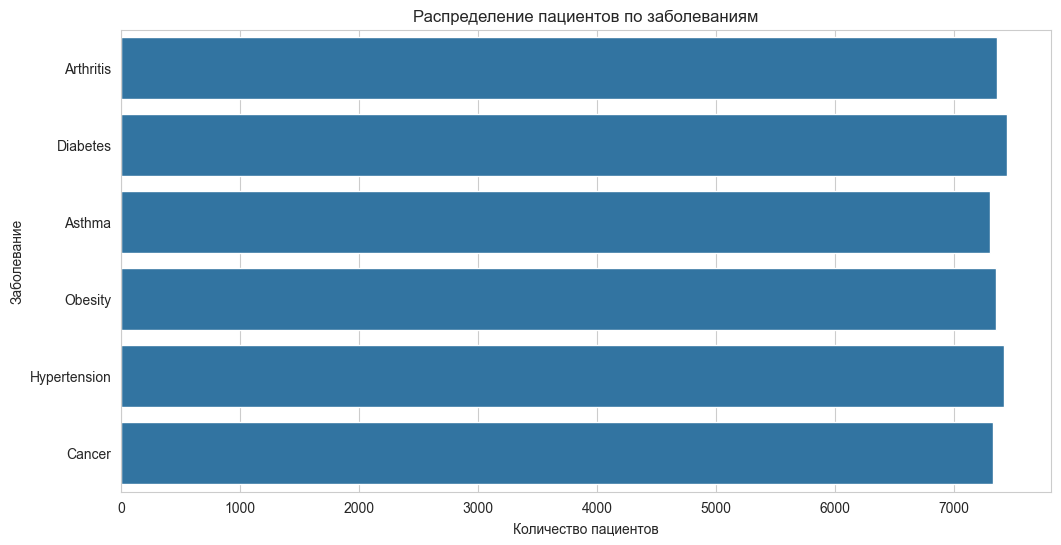

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(y=df_train['medical_condition'])
plt.title('Распределение пациентов по заболеваниям')
plt.xlabel('Количество пациентов')
plt.ylabel('Заболевание')
plt.show()

In [15]:
df_train['medical_condition'].value_counts()

medical_condition
Diabetes        7447
Hypertension    7427
Arthritis       7368
Obesity         7353
Cancer          7330
Asthma          7309
Name: count, dtype: int64

**Вывод:** наш целевой признак распределен почти равномерно на 6 классов: от 7338 до 7482 на класс

Проанализируем распределение признаков `age` и `billing_amount`

Но перед этим посмотрим на кол-во отрицательных значений `billing_amount` в нашем датасете

In [16]:
df_train.query('billing_amount < 0').billing_amount.count()

np.int64(93)

94 строки с отрицательным значением `billing_amount`. Это не так много, удалим их

In [17]:
df_train = df_train.query('billing_amount >= 0')

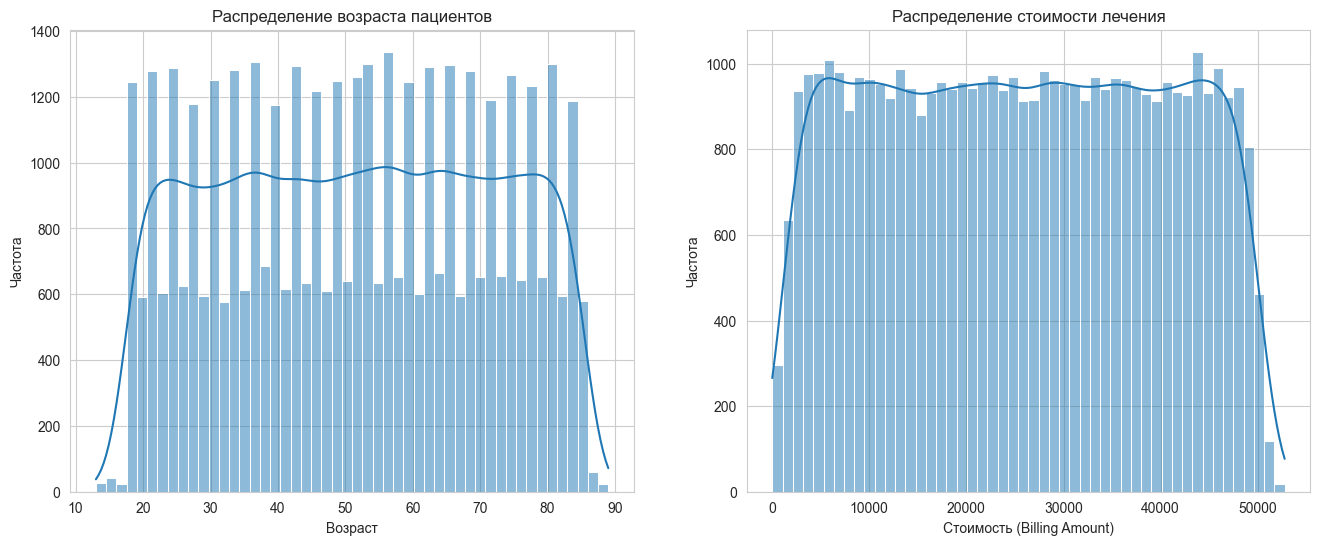

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df_train['age'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Распределение возраста пациентов')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Частота')

sns.histplot(df_train['billing_amount'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Распределение стоимости лечения')
axes[1].set_xlabel('Стоимость (Billing Amount)')
axes[1].set_ylabel('Частота')

plt.show()

**Вывод:** графики имеют нормальное распределение, что несвойственно для нормальных данных. Не бывает, что 20-летних госпитализируют также часто, как 80-летних. А распределение стоимости лечения абсолютно симметричное без хвоста

Сравним стоимость лечения (`billing_amount`) для каждого заболевания (`medical_condition`)

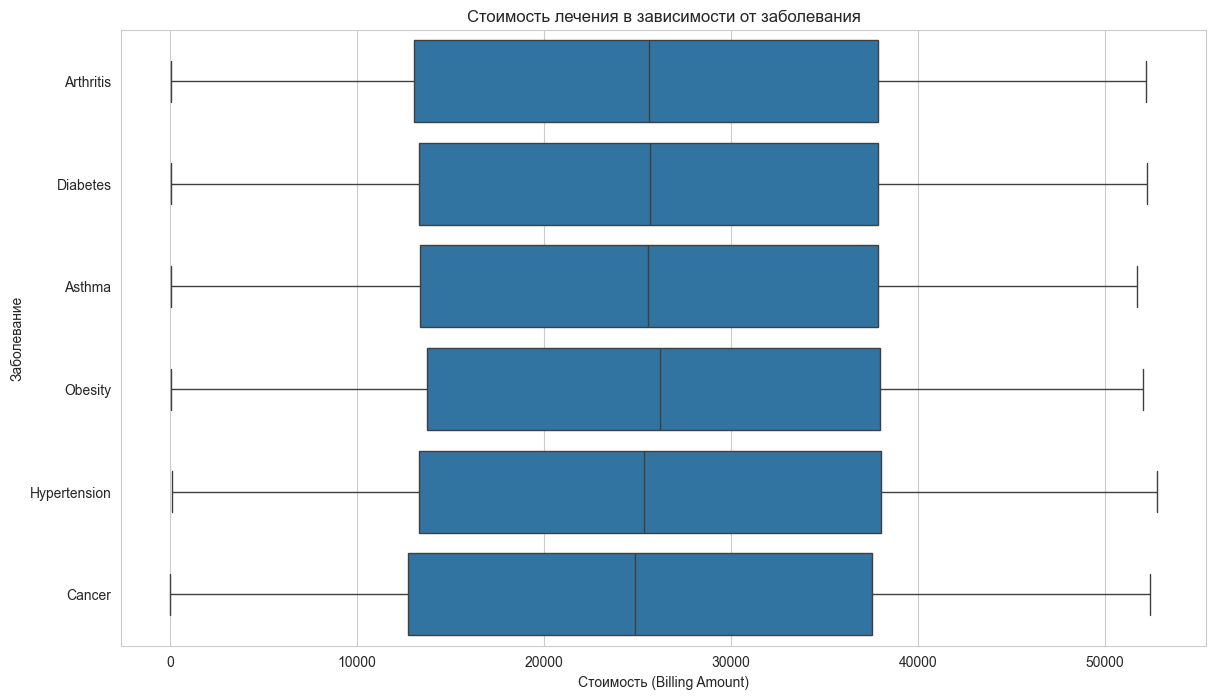

In [19]:
plt.figure(figsize=(14, 8))

sns.boxplot(x='billing_amount', y='medical_condition', data=df_train)
plt.title('Стоимость лечения в зависимости от заболевания')
plt.xlabel('Стоимость (Billing Amount)')
plt.ylabel('Заболевание')
plt.show()

**Вывод:** стоимость лечения каждого заболевания практически идентична, на уровне 25,000. И размах тоже очень похож от ~0 до ~52,000

Посмотрим, как тип госпитализации (`admission_type`) влияет на итоговую стоимость 

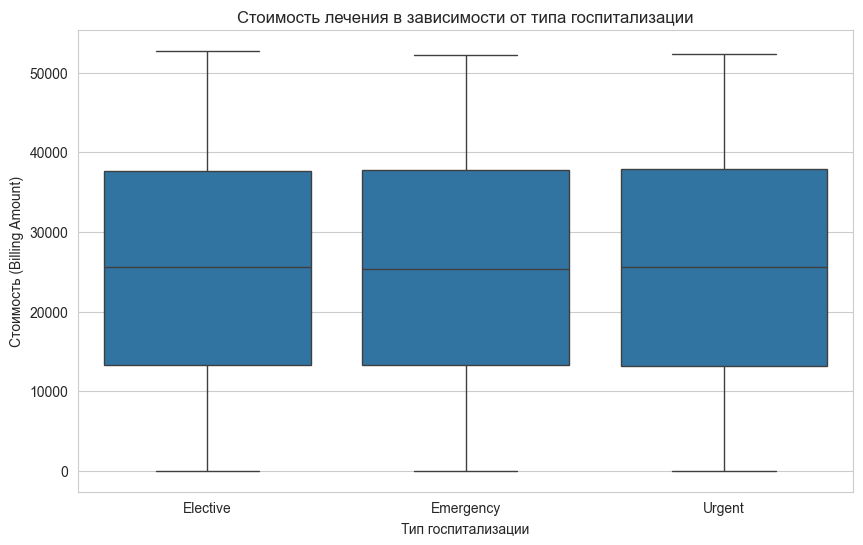

In [20]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='admission_type', y='billing_amount', data=df_train)
plt.title('Стоимость лечения в зависимости от типа госпитализации')
plt.xlabel('Тип госпитализации')
plt.ylabel('Стоимость (Billing Amount)')
plt.show()

**Вывод:** тип госпитализации не влияет на итоговую стоимость. В них нет никакой разницы. Можно бы было даже избавиться от этого признака

Посмотрим на кол-во уникальных записей врачей и больниц

In [21]:
print(f'doctor: {df_train.doctor.nunique()}')
print(f'hospital: {df_train.hospital.nunique()}')

doctor: 33071
hospital: 32357


Эти записи имеют слишком уникальных значений и потмоу несут мало информативности для модели

По итогу кодирования OneHot будет создано огромное кол-во признаков из-за чего датасет вырастет в огромном кол-ве (в ширь) 

Избавимся от этих признаков

In [22]:
df_train = df_train.drop(columns=['doctor', 'hospital'])

**Вывод по Анализу признаков**



Эти данные не несут никакой важной информации. Все данные нормальны распределены, все данные равномерно распределены, даже зацепиться не за что

Скорее всего и модели не за что будет зацепиться. Хоть данных и достаточно много, чтобы можон было получить хороший результат, сами данные не несут никакой информативной нагрузки

Если корреляция признаков покажет близкую к 0 корреляцию, то можно будет подтвердить вышесказанное и не ждать от модели хороших результатов

### Корреляция признаков

Построим матрицу корреляции для всех признаков

Посмотрим на линейные связи между ними

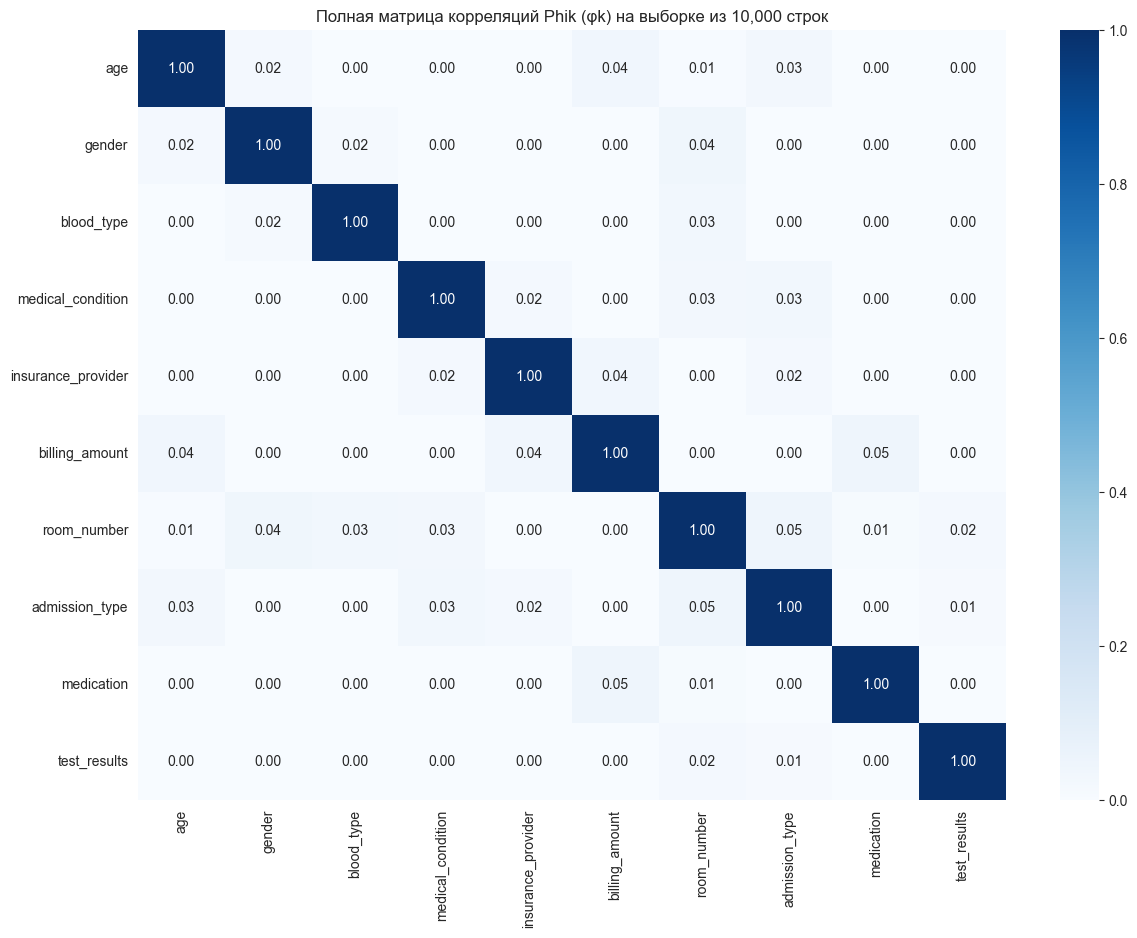

In [23]:
df_sample = df_train.sample(n=10000, random_state=42)
df_sample = df_sample.drop(columns=['date_of_admission', 'discharge_date'])

phik_matrix = df_sample.phik_matrix(interval_cols=['age', 'billing_amount', 'room_number'])

plt.figure(figsize=(14, 10))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1)
plt.title('Полная матрица корреляций Phik (φk) на выборке из 10,000 строк')
plt.show()

**Вывод по корреляции**

Корреляция между данными околонулевая и никаких линейных зависимостей в данных нет. Это потверждает ранее сказанное `Скорее всего и модели не за что будет зацепиться` и метрики будут достаточно низкими

### Формулирование и проверка гипотез

Сформируем и проверим гипотезы

**Гипотеза 1**

Средняя стоимость лечения (`billing_amount`) статистически значимо различается в зависимости от заболевания (`medical_condition`)

Нулевая гипотеза (H0): Средние стоимости лечения для всех заболеваний равны.

Альтернативная гипотеза (H1): Хотя бы одна пара средних стоимостей лечения различается.

In [24]:
conditions = df_train['medical_condition'].unique()
billing_by_condition = [df_train['billing_amount'][df_train['medical_condition'] == cond] for cond in conditions]

f_stat, p_value = f_oneway(*billing_by_condition)

print(f"F-статистика: {f_stat:.2f}")
print(f"P-значение: {p_value}")

if p_value < 0.05:
    print("Результат: P-значение < 0.05, отвергаем нулевую гипотезу. Стоимость лечения значимо различается в зависимости от заболевания")
else:
    print("Результат: P-значение >= 0.05, не можем отвергнуть нулевую гипотезу")

F-статистика: 1.99
P-значение: 0.07612420684088694
Результат: P-значение >= 0.05, не можем отвергнуть нулевую гипотезу


**Гипотеза 2**

Средняя стоимость лечения (`billing_amount`) статистически значимо различается между мужчинами и женщинами (`gender`)

Нулевая гипотеза (H0): Средняя стоимость лечения для мужчин равна средней стоимости лечения для женщин

Альтернативная гипотеза (H1): Средние стоимости лечения для мужчин и женщин не равны

In [25]:
male_billing = df_train[df_train['gender'] == 'Male']['billing_amount'].dropna()
female_billing = df_train[df_train['gender'] == 'Female']['billing_amount'].dropna()

t_stat, p_value = ttest_ind(male_billing, female_billing)

print(f"T-статистика: {t_stat:.2f}")
print(f"P-значение: {p_value}")

if p_value < 0.05:
    print("Результат: P-значение < 0.05, отвергаем нулевую гипотезу")
else:
    print("Результат: P-значение >= 0.05, не можем отвергнуть нулевую гипотезу")

T-статистика: 1.16
P-значение: 0.24431758502479856
Результат: P-значение >= 0.05, не можем отвергнуть нулевую гипотезу


**Вывод по гипотезам**

Результаты показывают, что скорее всего никаких различий, особенностях в данных нет, чтобы модель выучила какие-либо закономерности. Никаких закономерностей, скорее всего, в данных и нет

*Гипотеза 1*

Мы НЕ можем отвергнуть, что средние стоимости лечения для всех заболеваний равны

*Гипотеза 2*

Мы НЕ можем отвергнуть, что средняя стоимость лечения для мужчин равна средней стоимости лечения для женщин

## Подготовка к обучению (Medical Condition)

Обучим модель по целевому признаку `medical_condition`

Разделим данные

In [26]:
X = df_train.drop(columns=['medical_condition'])
y = df_train['medical_condition']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Напишем свой трансформер для создания признаков

Признаки, которые мы создадим:
1. `days_in_hospital` - кол-во дней в больнице
2. `room_floor` - номер этажа (вместо номера палаты)

In [28]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_['date_of_admission'] = pd.to_datetime(X_['date_of_admission'])
        X_['discharge_date'] = pd.to_datetime(X_['discharge_date'])
        X_['days_in_hospital'] = (X_['discharge_date'] - X_['date_of_admission']).dt.days
        
        X_['room_floor'] = (X_['room_number'] // 100).astype(str)
        
        X_ = X_.drop(columns=['date_of_admission', 'discharge_date', 'room_number'])
        return X_

Используем генератор признаков, чтобы определить типы колонок

In [29]:
feature_gen = FeatureGenerator()
X_train_featured = feature_gen.fit_transform(X_train)
X_test_featured = feature_gen.transform(X_test)

numeric_features = X_train_featured.select_dtypes(include=['float64']).columns.tolist()
categorical_features = X_train_featured.select_dtypes(include=['object']).columns.tolist()

all_feature_names = X_train_featured.columns.tolist()
cat_feature_indices = [all_feature_names.index(col) for col in categorical_features]

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

Числовые признаки: ['age', 'billing_amount', 'days_in_hospital']
Категориальные признаки: ['gender', 'blood_type', 'insurance_provider', 'admission_type', 'medication', 'test_results', 'room_floor']


Создадим пайплайн, в которм будет
1. Создание наших новых признаков
2. Заполнение пропусков
3. Кодирование признаков

In [30]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Обучение моделей (Medical Condition)

Обучим несколько моделей на CV, сравним их, выберем лучшую, переобучим ее и оценим.

Будем учить такие модели:
* Logistic Regression
* RandomForestClassifier
* LGBMClassifier
* XGBCClassifier


Метрику будем использовать `f1_weighted`

У нас задача многоклассовой классификации, в нашем случае важен баланс между разными типами ошибок, поэтому мы вбираем F1, а не Accuracy, например

Хоть у нас классы почти и сбалансированные, будем использовать weighted, как универсальное решение

### Logistic Regression

In [32]:
study_logreg = optuna.create_study(direction="maximize")
trial = 30

for i in range(trial): 
    trial = study_logreg.ask() 

    params = {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'solver': 'liblinear',
        'random_state': 42
    }   

    pipeline = Pipeline(steps=[
        ('feature_generator', FeatureGenerator()),
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(**params))
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=3, scoring='f1_weighted').mean()
    study_logreg.tell(trial, score)
    print(f"Итерация {i}: f1_weighted = {score:.4f}")

print("Лучшие параметры:", study_logreg.best_params)
print(f"Лучший f1_weighted на CV: {study_logreg.best_value:.4f}")

[I 2025-10-28 10:02:37,297] A new study created in memory with name: no-name-c58fd85a-2738-46ae-8452-81e4942b8c50


Итерация 0: f1_weighted = 0.1631
Итерация 1: f1_weighted = 0.1637
Итерация 2: f1_weighted = 0.1581
Итерация 3: f1_weighted = 0.1634
Итерация 4: f1_weighted = 0.1635
Итерация 5: f1_weighted = 0.1582
Итерация 6: f1_weighted = 0.1633
Итерация 7: f1_weighted = 0.1621
Итерация 8: f1_weighted = 0.1632
Итерация 9: f1_weighted = 0.1632
Итерация 10: f1_weighted = 0.1634
Итерация 11: f1_weighted = 0.1635
Итерация 12: f1_weighted = 0.1631
Итерация 13: f1_weighted = 0.1634
Итерация 14: f1_weighted = 0.1630
Итерация 15: f1_weighted = 0.1628
Итерация 16: f1_weighted = 0.1633
Итерация 17: f1_weighted = 0.1632
Итерация 18: f1_weighted = 0.1634
Итерация 19: f1_weighted = 0.1632
Итерация 20: f1_weighted = 0.1633
Итерация 21: f1_weighted = 0.1634
Итерация 22: f1_weighted = 0.1623
Итерация 23: f1_weighted = 0.1635
Итерация 24: f1_weighted = 0.1641
Итерация 25: f1_weighted = 0.1622
Итерация 26: f1_weighted = 0.1634
Итерация 27: f1_weighted = 0.1640
Итерация 28: f1_weighted = 0.1636
Итерация 29: f1_weighted

###  RandomForestClassifier

In [33]:
study_rf = optuna.create_study(direction="maximize")
trial = 5

for i in range(trial): 
    trial = study_rf.ask() 

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }

    pipeline = Pipeline(steps=[
        ('feature_generator', FeatureGenerator()),
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(**params))
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=3, scoring='f1_weighted').mean()
    study_rf.tell(trial, score)
    print(f"Итерация {i}: f1_weighted = {score:.4f}")

print("Лучшие параметры:", study_rf.best_params)
print(f"Лучший f1_weighted на CV: {study_rf.best_value:.4f}")

[I 2025-10-28 10:02:52,617] A new study created in memory with name: no-name-9a6adbf8-5d17-43a8-96f5-ef92b8f029e2


Итерация 0: f1_weighted = 0.2035
Итерация 1: f1_weighted = 0.2079
Итерация 2: f1_weighted = 0.1858
Итерация 3: f1_weighted = 0.1757
Итерация 4: f1_weighted = 0.2162
Лучшие параметры: {'n_estimators': 720, 'max_depth': 20, 'min_samples_leaf': 5}
Лучший f1_weighted на CV: 0.2162


### LGBMClassifier

In [34]:
study_lgbm = optuna.create_study(direction="maximize")
trial = 5

for i in range(trial): 
    trial = study_lgbm.ask() 

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'random_state': 42,
        'verbose': -1
    }

    pipeline = Pipeline(steps=[
        ('feature_generator', FeatureGenerator()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**params))
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=3, scoring='f1_weighted').mean()
    study_lgbm.tell(trial, score)
    print(f"Итерация {i}: f1_weighted = {score:.4f}")

print("Лучшие параметры:", study_lgbm.best_params)
print(f"Лучший f1_weighted на CV: {study_lgbm.best_value:.4f}")

[I 2025-10-28 10:04:45,143] A new study created in memory with name: no-name-9a9b2036-2cfc-4b1c-8afc-030b2e959c1d


Итерация 0: f1_weighted = 0.2139
Итерация 1: f1_weighted = 0.1776
Итерация 2: f1_weighted = 0.2170
Итерация 3: f1_weighted = 0.2127
Итерация 4: f1_weighted = 0.2193
Лучшие параметры: {'n_estimators': 431, 'learning_rate': 0.062381279862820355, 'num_leaves': 143}
Лучший f1_weighted на CV: 0.2193


### XGBClassifier

In [35]:
study_xgb = optuna.create_study(direction="maximize")
trial = 5

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

categorical_features_low_card = [col for col in categorical_features if col not in ['doctor', 'hospital']]

for i in range(trial):
    trial = study_xgb.ask() 

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'n_jobs': -1 
    }
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features), 
        ('cat', categorical_transformer, categorical_features_low_card)
    ])
    
    pipeline = Pipeline(steps=[
        ('feature_generator', FeatureGenerator()),
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(**params))
    ])
    
    score = cross_val_score(pipeline, X_train, y_train_encoded, n_jobs=-1, cv=3, scoring='f1_weighted').mean()
    study_xgb.tell(trial, score)
    print(f"Итерация {i}: f1_weighted = {score:.4f}")

print("Лучшие параметры:", study_xgb.best_params)
print(f"Лучший f1_weighted на CV: {study_xgb.best_value:.4f}")

[I 2025-10-28 10:05:39,419] A new study created in memory with name: no-name-ff51c554-55cd-4519-97cd-b37f9c9cd536


Итерация 0: f1_weighted = 0.2197
Итерация 1: f1_weighted = 0.1797
Итерация 2: f1_weighted = 0.2258
Итерация 3: f1_weighted = 0.2113
Итерация 4: f1_weighted = 0.2224
Лучшие параметры: {'n_estimators': 969, 'learning_rate': 0.13838665421870835, 'max_depth': 10, 'subsample': 0.8946383071912993, 'colsample_bytree': 0.7613396660919745}
Лучший f1_weighted на CV: 0.2258


### Результаты на CV

In [36]:
results = {
    "Logistic Regression": {"score": study_logreg.best_value, "params": study_logreg.best_params},
    "RandomForest": {"score": study_rf.best_value, "params": study_rf.best_params},
    "LGBM": {"score": study_lgbm.best_value, "params": study_lgbm.best_params},
    "XGB": {"score": study_xgb.best_value, "params": study_xgb.best_params}
}

df_cv = pd.DataFrame(results).T  
df_cv.sort_values(by='score', ascending=False)

,score,params
XGB,0.22576,"{'n_estimators': 969, 'learning_rate': 0.13838..."
LGBM,0.219345,"{'n_estimators': 431, 'learning_rate': 0.06238..."
RandomForest,0.216172,"{'n_estimators': 720, 'max_depth': 20, 'min_sa..."
Logistic Regression,0.164086,{'C': 0.006463691335467353}


In [37]:
best_model_name = max(results, key=lambda model: results[model]["score"])
best_model_info = results[best_model_name]

print(f"Лучшая модель: {best_model_name} с результатом: {best_model_info['score']}")

Лучшая модель: XGB с результатом: 0.22575997982329757


Результаты CV показали, что наша лучшая модель: XGB

Метрика f1_weight на CV: 0.2258

### Финальное обучение лучшей модели

In [38]:
final_classifier = xgb.XGBClassifier(**best_model_info['params'], random_state=42, n_jobs=-1)

numeric_transformer = Pipeline(steps=[
    ('scaler', KNNImputer(n_neighbors=5)), 
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features), 
    ('cat', categorical_transformer, categorical_features)
])

final_pipeline = Pipeline(steps=[
    ('feature_generator', FeatureGenerator()),
    ('preprocessor', preprocessor),
    ('classifier', final_classifier)
])

print(f"Обучаем финальную модель {best_model_name}")
final_pipeline.fit(X_train, y_train_encoded)

Обучаем финальную модель XGB


,steps,"[('feature_generator', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Оценка лучшей модели (Medical Condition)

Посмотрим на распределение ошибок модели и выведем матрицу ошибок

In [39]:
y_pred_encoded = final_pipeline.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Arthritis       0.24      0.24      0.24      1472
      Asthma       0.25      0.24      0.24      1459
      Cancer       0.26      0.26      0.26      1463
    Diabetes       0.24      0.24      0.24      1486
Hypertension       0.26      0.28      0.27      1482
     Obesity       0.26      0.25      0.26      1467

    accuracy                           0.25      8829
   macro avg       0.25      0.25      0.25      8829
weighted avg       0.25      0.25      0.25      8829



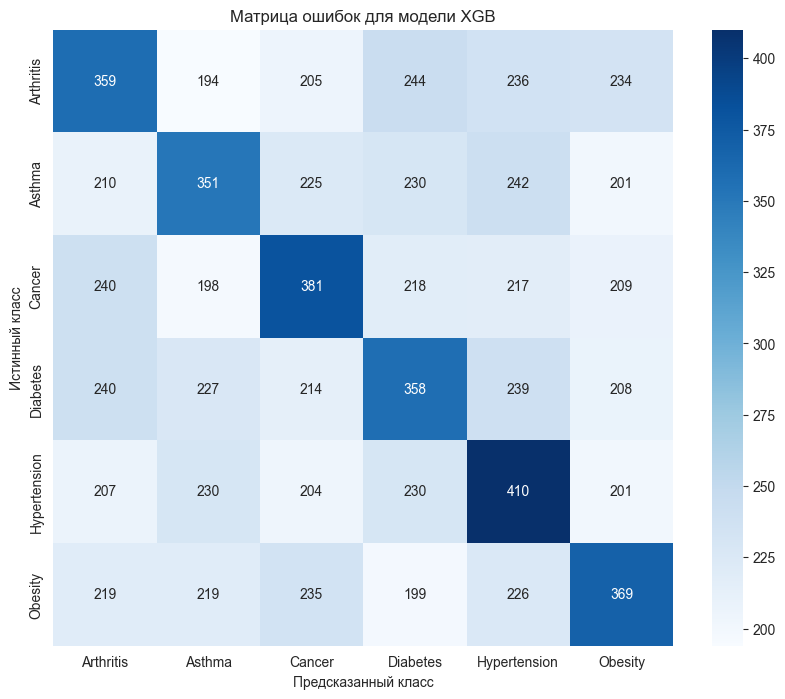

In [41]:
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Матрица ошибок для модели {best_model_name}')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

Лучше всего наша модель предсказывает класс `Hypertension`, а хуже всего `Asthma`

Но общая метрика не высока. Модель совершает много ошибок по причине отсутствия большого кол-ва связей в данных

Сравним нашу модель с DummyClassifier

In [42]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

print(classification_report(y_test, y_pred_dummy))

              precision    recall  f1-score   support

   Arthritis       0.18      0.17      0.18      1472
      Asthma       0.17      0.17      0.17      1459
      Cancer       0.17      0.16      0.16      1463
    Diabetes       0.17      0.17      0.17      1486
Hypertension       0.17      0.17      0.17      1482
     Obesity       0.17      0.18      0.17      1467

    accuracy                           0.17      8829
   macro avg       0.17      0.17      0.17      8829
weighted avg       0.17      0.17      0.17      8829



Наша модель лучше (0.28), чем DummyClassifier (0.17), что уже неплохой результат для этих данных

### Важность признаков

Визуализирцем важность признаков для нашей лучшей модели

Возьмем топ 15 самых важных признаков

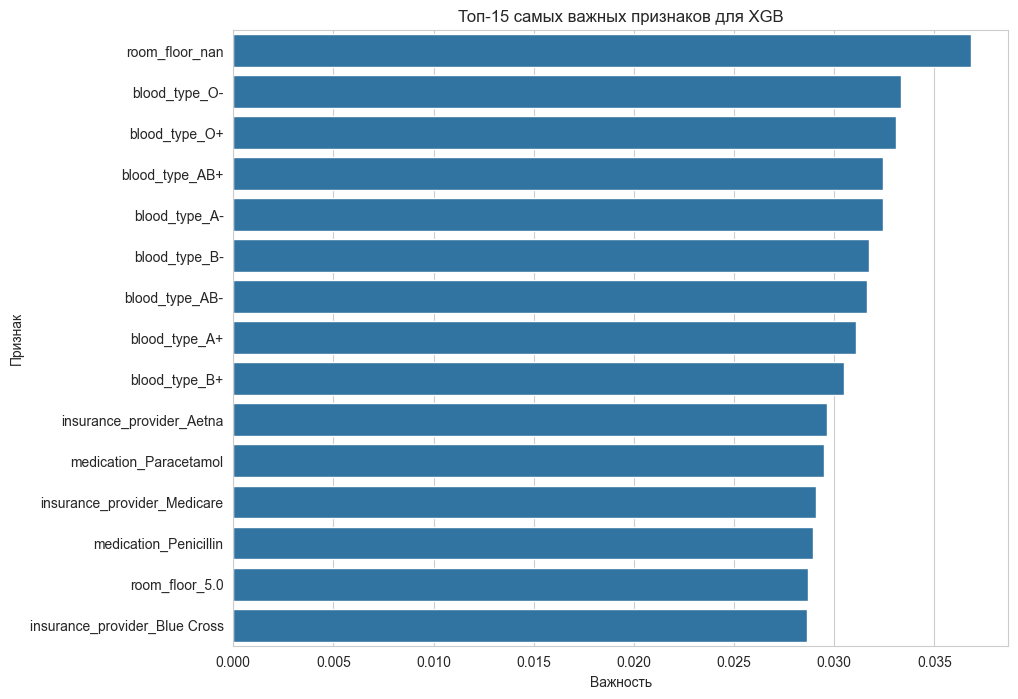

In [45]:
trained_classifier = final_pipeline.named_steps['classifier']
trained_preprocessor = final_pipeline.named_steps['preprocessor']

ohe_feature_names = trained_preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features_low_card)
all_feature_names = numeric_features + list(ohe_feature_names)

importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': trained_classifier.feature_importances_
}).sort_values('importance', ascending=False).head(15)


plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances)
plt.title(f'Топ-15 самых важных признаков для {best_model_name}')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

Самым важным значением признака для модели является, что номер этажа платы не заполнен (чуть более 1300 значений). Возможно, что пропуски в данных не случайны

На втором месте для модели по важности - тип крови пациента

## Подготовка к обучению (Billing Amount)

Снова разделим данные, но с другой целевой переменной

In [55]:
X_reg = df_train.drop(columns=['billing_amount'])
y_reg = df_train['billing_amount']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=42
)

In [56]:
temp_transformer_reg = FeatureGenerator()
X_train_featured_reg = temp_transformer_reg.fit_transform(X_train_reg)

numeric_features_reg = X_train_featured_reg.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features_reg = X_train_featured_reg.select_dtypes(include=['object']).columns.tolist()

categorical_features_low_card_reg = [col for col in categorical_features_reg if col not in ['hospital']]

print("Числовые признаки:", numeric_features_reg)
print("Категориальные признаки:", categorical_features_low_card_reg)

Числовые признаки: ['age', 'days_in_hospital']
Категориальные признаки: ['gender', 'blood_type', 'medical_condition', 'insurance_provider', 'admission_type', 'medication', 'test_results', 'room_floor']


In [59]:
numeric_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_reg = ColumnTransformer(transformers=[
    ('num', numeric_transformer_reg, numeric_features_reg),
    ('cat', categorical_transformer_reg, categorical_features_reg)
])

## Обучение моделей (Billing Amount)

Также, как и на задаче классификации: обучим несколько моделей на CV, сравним их, выберем лучшую, переобучим ее и оценим.

Будем учить такие модели:
* Logistic Regression
* LGBMClassifier
* XGBCClassifier


Метрику будем использовать `RMSE`

RMSE измеряется в тех же единицах, что и целевая переменная, ее удобно интерпритировать
Большие ошибки штрафуются сильнее, чем маленькие

Для Optuna будем использовать `neg_root_mean_squared_error`, так как Optuna по умолчанию максимизирует значение, а нам нужно минимизировать ошибку

### Ridge Regression

In [61]:
study_ridge = optuna.create_study(direction="maximize")
trial = 30

for i in range(trial): 
    trial = study_ridge.ask() 

    params = {
        'alpha': trial.suggest_float('alpha', 1e-3, 1e3, log=True), 
        'solver': 'auto',
        'random_state': 42
    }   


    pipeline = Pipeline(steps=[
        ('feature_generator', FeatureGenerator()),
        ('preprocessor', preprocessor_reg),
        ('regressor', Ridge(**params))
    ])
    
    score = cross_val_score(pipeline, X_train_reg, y_train_reg, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean()
    study_ridge.tell(trial, score)
    print(f"Итерация {i}: neg_rmse = {score:.4f}")

print("Лучшие параметры:", study_ridge.best_params)
print(f"Лучший neg_rmse на CV: {study_ridge.best_value:.4f}\n")

[I 2025-10-28 11:09:21,638] A new study created in memory with name: no-name-28b5c1fe-31c9-45bf-8460-675f1b67f283


Итерация 0: neg_rmse = -14215.3287
Итерация 1: neg_rmse = -14220.5702
Итерация 2: neg_rmse = -14220.5689
Итерация 3: neg_rmse = -14220.5719
Итерация 4: neg_rmse = -14220.4759
Итерация 5: neg_rmse = -14220.5721
Итерация 6: neg_rmse = -14218.9611
Итерация 7: neg_rmse = -14220.0585
Итерация 8: neg_rmse = -14213.6640
Итерация 9: neg_rmse = -14220.5574
Итерация 10: neg_rmse = -14213.0702
Итерация 11: neg_rmse = -14213.6659
Итерация 12: neg_rmse = -14217.2097
Итерация 13: neg_rmse = -14218.9336
Итерация 14: neg_rmse = -14213.5487
Итерация 15: neg_rmse = -14220.2838
Итерация 16: neg_rmse = -14217.8086
Итерация 17: neg_rmse = -14219.7011
Итерация 18: neg_rmse = -14216.8994
Итерация 19: neg_rmse = -14220.4898
Итерация 20: neg_rmse = -14215.9084
Итерация 21: neg_rmse = -14213.3195
Итерация 22: neg_rmse = -14213.5769
Итерация 23: neg_rmse = -14218.2959
Итерация 24: neg_rmse = -14212.3961
Итерация 25: neg_rmse = -14212.2095
Итерация 26: neg_rmse = -14216.4757
Итерация 27: neg_rmse = -14219.6621
Ит

### LGBMRegressor

In [63]:
study_lgbm_reg = optuna.create_study(direction="maximize")
trial = 15

for i in range(trial): 
    trial = study_lgbm_reg.ask() 

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1
    }
    
    pipeline = Pipeline(steps=[
        ('feature_generator', FeatureGenerator()),
        ('preprocessor', preprocessor_reg), 
        ('regressor', lgb.LGBMRegressor(**params))
    ])
    
    score = cross_val_score(pipeline, X_train_reg, y_train_reg, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean()
    study_lgbm_reg.tell(trial, score)
    print(f"Итерация {i}: neg_rmse = {score:.4f}")

print("Лучшие параметры:", study_lgbm_reg.best_params)
print(f"Лучший neg_rmse на CV: {study_lgbm_reg.best_value:.4f}\n")

[I 2025-10-28 11:11:02,365] A new study created in memory with name: no-name-2ef8cabe-2059-40be-bc3b-32ab02e92ce6


Итерация 0: neg_rmse = -14585.8605
Итерация 1: neg_rmse = -14492.0970
Итерация 2: neg_rmse = -15451.9508
Итерация 3: neg_rmse = -14732.9254
Итерация 4: neg_rmse = -14922.0789
Итерация 5: neg_rmse = -14693.7929
Итерация 6: neg_rmse = -14431.9214
Итерация 7: neg_rmse = -15038.3024
Итерация 8: neg_rmse = -14399.1693
Итерация 9: neg_rmse = -14431.5199
Итерация 10: neg_rmse = -14414.9541
Итерация 11: neg_rmse = -14525.5227
Итерация 12: neg_rmse = -14289.7775
Итерация 13: neg_rmse = -14699.9235
Итерация 14: neg_rmse = -14882.8422
Лучшие параметры: {'n_estimators': 870, 'learning_rate': 0.011990443369565673, 'num_leaves': 68}
Лучший neg_rmse на CV: -14289.7775




### XGBRegressor

In [66]:
study_xgb_reg = optuna.create_study(direction="maximize")
trial = 15

for i in range(trial):
    trial = study_xgb_reg.ask() 

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'n_jobs': -1 
    }
    
    pipeline = Pipeline(steps=[
        ('feature_generator', FeatureGenerator()),
        ('preprocessor', preprocessor_reg), 
        ('regressor', xgb.XGBRegressor(**params))
    ])
    
    score = cross_val_score(pipeline, X_train_reg, y_train_reg, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean()
    study_xgb_reg.tell(trial, score)
    print(f"Итерация {i}: neg_rmse = {score:.4f}")

print("Лучшие параметры:", study_xgb_reg.best_params)
print(f"Лучший neg_rmse на CV: {study_xgb_reg.best_value:.4f}\n")

[I 2025-10-28 11:12:33,305] A new study created in memory with name: no-name-b3294cc4-d004-48d7-9638-d6eceaaa35cf


Итерация 0: neg_rmse = -15475.1352
Итерация 1: neg_rmse = -15884.3323
Итерация 2: neg_rmse = -15231.9638
Итерация 3: neg_rmse = -14464.1418
Итерация 4: neg_rmse = -14329.3160
Итерация 5: neg_rmse = -14232.8758
Итерация 6: neg_rmse = -15306.4294
Итерация 7: neg_rmse = -15114.2207
Итерация 8: neg_rmse = -14569.3003
Итерация 9: neg_rmse = -14793.9940
Итерация 10: neg_rmse = -14223.1489
Итерация 11: neg_rmse = -14220.9215
Итерация 12: neg_rmse = -14224.9913
Итерация 13: neg_rmse = -14267.6160
Итерация 14: neg_rmse = -14763.7648
Лучшие параметры: {'n_estimators': 590, 'learning_rate': 0.010271594143747396, 'max_depth': 3, 'subsample': 0.9797750382487058, 'colsample_bytree': 0.7073733681965879}
Лучший neg_rmse на CV: -14220.9215



### Финальное обучение лучшей модели

In [70]:
results_reg = {
    "Ridge": {"score": study_ridge.best_value, "params": study_ridge.best_params},
    "LGBM": {"score": study_lgbm_reg.best_value, "params": study_lgbm_reg.best_params},
    "XGBoost": {"score": study_xgb_reg.best_value, "params": study_xgb_reg.best_params}
}

df_cv_reg = pd.DataFrame(results_reg).T  
df_cv_reg.sort_values(by='score', ascending=False)

,score,params
Ridge,-14212.209487,{'alpha': 993.2945757614999}
XGBoost,-14220.92149,"{'n_estimators': 590, 'learning_rate': 0.01027..."
LGBM,-14289.77754,"{'n_estimators': 870, 'learning_rate': 0.01199..."


In [68]:
best_model_name_reg = max(results_reg, key=lambda model: results_reg[model]["score"])
best_model_info_reg = results_reg[best_model_name_reg]

print(f"Лучшая модель: {best_model_name_reg}")

Лучшая модель: Ridge


In [69]:
final_regressor = Ridge(**best_model_info_reg['params'], random_state=42)

final_pipeline_reg = Pipeline(steps=[
    ('feature_generator', FeatureGenerator()),
    ('preprocessor', preprocessor_reg),
    ('regressor', final_regressor)
])

final_pipeline_reg.fit(X_train_reg, y_train_reg)

,steps,"[('feature_generator', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Наша лучшая модель: Ridge с метрикой на CV: 14212

## Оценка лучшей модели (Billing Amount)

Посмотрим на результаты на тесте

In [78]:
y_pred_reg = final_pipeline_reg.predict(X_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f'RMSE: {rmse:,.2f}')
print(f'MAE: {mae:,.2f}')
print(f'R2: {r2:,.2f}')

RMSE: 14,223.48
MAE: 12,304.09
R2: -0.00


Сравним с DummyRegressor

In [77]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_reg, y_train_reg)
y_pred_dummy_reg = dummy_reg.predict(X_test_reg)


rmse_dummy = np.sqrt(mean_squared_error(y_test_reg, y_pred_dummy_reg))
mae_dummy = mean_absolute_error(y_test_reg, y_pred_dummy_reg)
r2_dummy = r2_score(y_test_reg, y_pred_dummy_reg)

print(f'DummyClassifier')
print(f'RMSE: {rmse_dummy:,.2f}')
print(f'MAE: {mae_dummy:,.2f}')
print(f'R2: {r2_dummy:,.2f}')

DummyClassifier
RMSE: 14,221.85
MAE: 12,306.02
R2: -0.00


Сравнивая наши лучшие результаты в DummyClassifier, можем сделать вывод, что смысла от этой модели нет

DummyClassifier лучше "предсказывает" по среднему значению, чем обученная модель

Для построения работающей модели необходимо добавить признаки, которые имеют прямую связь со стоимостью лечения, например: количество проведенных процедур, тип операции, стоимость назначенных медикаментов и т.д.

(или иметь не синтетические признаки, которые мы имеем сейчас)

### Важность признаков

Посмотрим на важность наших признаков лучшей модели

C:\Users\koziy\AppData\Local\Temp\ipykernel_11828\1248782301.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=top_coefs, palette='coolwarm')


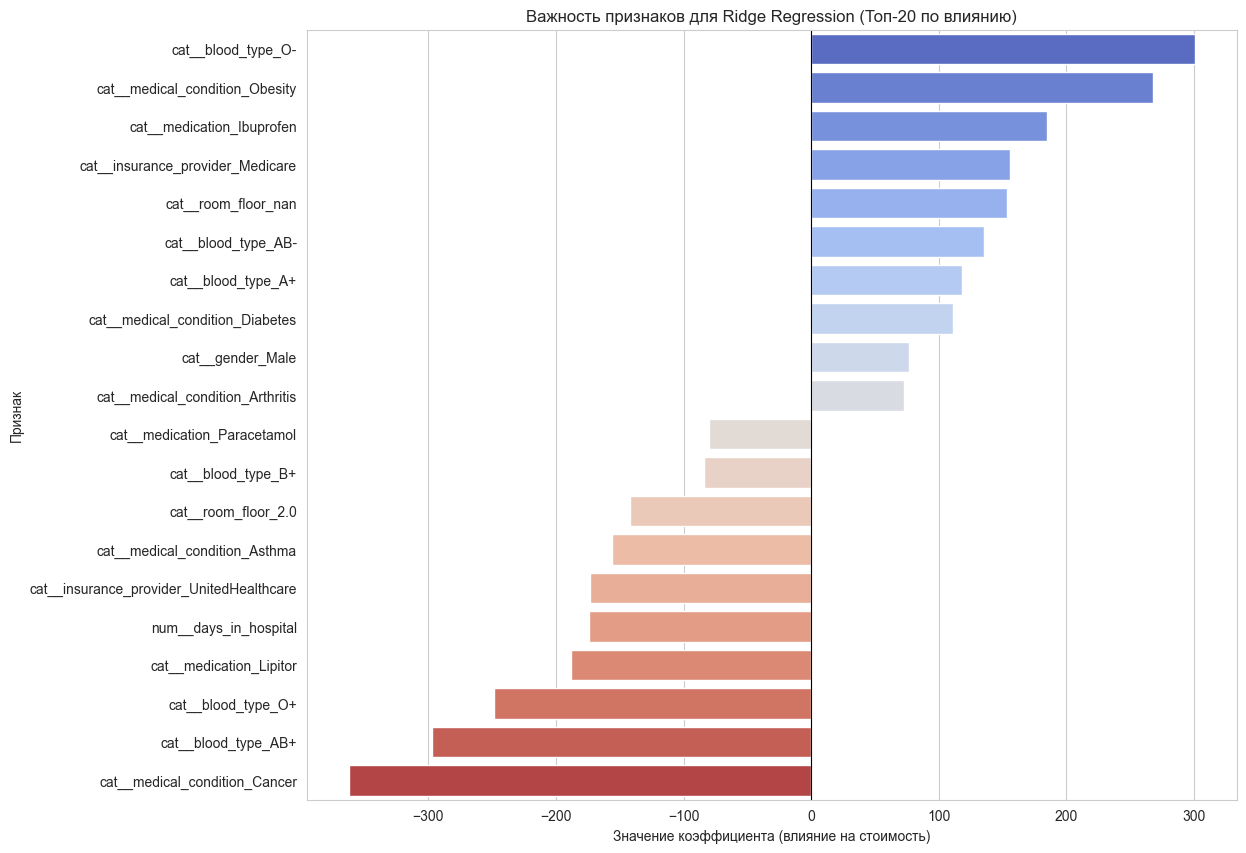

In [84]:
trained_regressor = final_pipeline_reg.named_steps['regressor']
trained_preprocessor = final_pipeline_reg.named_steps['preprocessor']

coefficients = trained_regressor.coef_
feature_names = trained_preprocessor.get_feature_names_out()

coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
coef_df['abs_coefficient'] = np.abs(coef_df['coefficient'])
coef_df = coef_df.sort_values('coefficient', ascending=False)

top_positive = coef_df.head(10)
top_negative = coef_df.tail(10)
top_coefs = pd.concat([top_positive, top_negative])


plt.figure(figsize=(12, 10))
sns.barplot(x='coefficient', y='feature', data=top_coefs, palette='coolwarm')
plt.title('Важность признаков для Ridge Regression (Топ-20 по влиянию)')
plt.xlabel('Значение коэффициента (влияние на стоимость)')
plt.ylabel('Признак')
plt.axvline(0, color='black', linewidth=0.8)
plt.show()

Признаки, которые больше всего влияют на стоимость

С одной стороны:
1. Тип крови: О-
2. Medical Condition: Obesity
3. Лекарство: Ibuprofen

С другой стороны:
1. Medical Condition: Cancer
2. Тип крови: AB+
3. Тип крови: О+

## Вывод

По итогу проекта было выполнено:
1. Анализ синтетических данных
2. Построению моделей для предсказания диагноза пациента
3. Построению моделей для стоимости лечения пациента

Для каждой задачи построения модели было выполнено:
1. Поиск лучшей модели среди нескольких
2. Тренировка модели на кросс-валидации
3. Оценка лучшей модели
4. Сравнение с Dummy моделью

В ходе исследования было выявлено, что данные имеют слабо выраженные зависимости. Корреляционный анализ Phik показал практически нулевые связи между признаками и целевой переменной.

### Основные результаты

1. Задача классификации (предсказание `medical_condition`):
*   Были протестированы четыре модели: Logistic Regression, RandomForest, LGBM и XGBoost. Гиперпараметры подбирались с помощью Optuna.
*   Лучшей моделью на кросс-валидации оказался XGBoost с метрикой f1-weighted = 0.23.
*   На тестовой выборке финальная модель показала f1-weighted = 0.25. Результат превосходит базовую модель `DummyClassifier` (f1-weighted = 0.17). Модель уловила некоторые закономерности, однако общая предсказательная способность остаётся низкой.
*   Наиболее важными признаками для модели оказались отсутствие информации об этаже палаты (`room_floor_nan`) и группа крови (`blood_type`).

2. Задача регрессии (предсказание `billing_amount`):
*   Были протестированы модели Ridge, LGBM и XGBoost.
*   Лучшей моделью на кросс-валидации стала Ridge Regression с RMSE = 14,212.
*   На тестовой выборке финальная модель показала RMSE = 14,223 и коэффициент детерминации R² = -0.00. Этот результат оказался на уровне, чем у базовой модели `DummyRegressor`, которая просто предсказывает среднее значение.
*   Это подтверждает вывод, сделанный на этапе EDA: в предоставленных данных отсутствуют признаки, позволяющие делать качественные прогнозы стоимости лечения.

### Итого

По проекту провелась полноценная работа. Однако вывод заключается в том, что предоставленные синтетические данные имеют низкую предсказательную ценность. Распределения признаков и их взаимосвязи не отражают реальных закономерностей.

Для построения работающих и полезных моделей нужны признаки, которые имеют связь с целевыми переменными